In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sb
from DeepMRI import DeepMRI
import matplotlib.pyplot as plt
import SegAN_IO_arch as SegAN_IO
import SegAN_IO_Concat_arch as SegAN_Concat

### Evaluating SeganIO on every dataset modality
This function allows to evaluate a model on a desired dataset. If you are using a mother other than SegAN_IO, please import it as arch

In [2]:
def evaluate_on(modelname_to_load, checkpoint_to_load, target_datasets, target_mri_types, output_csv, arch=SegAN_IO):
    '''
    Evaluates a given model on a source dataset (the one it has been used for training) and then on a target dataset.
    :param modelname_to_load: The name of the model to load
    :param checkpoint_to_load: Filename of the checkpoint to load. Can be 'last'.
    :param target_dataset: List of dataset names on which evaluate the model
    :param target_mri_type: List of MRI types (as lists) on which evaluate the model.
    :param output_csv: Where to store the results. The csv will contain one row for each evaluated dataset
    '''

    gan = DeepMRI(batch_size=64, size=160, mri_channels=len(target_mri_types[0]), model_name=modelname_to_load)
    gan.build_model(load_model=gan.save_path+checkpoint_to_load, seed=1234567890, arch=arch)
    
    for target_dataset, target_mri_type in zip(target_datasets, target_mri_types):
        print("\nEvaluating on {}-{}".format(target_dataset, ','.join(target_mri_type)))
        gan.load_dataset(dataset=target_dataset, mri_types=target_mri_type)
        gan.evaluate(output_csv)
    
    print("Decorating csv with dataset info")
    eval_log = pd.read_csv(output_csv, index_col=0)
    eval_log['dataset'] =  target_datasets
    eval_log['mri_types'] = [','.join(target_mri_type) for target_mri_type in target_mri_types]
    eval_log.to_csv(output_csv)
    print("Output saved to {}".format(output_csv))
    
def plot_csv(output_csv, metrics=['dice_score', 'precision', 'sensitivity']):
    log = pd.read_csv(output_csv, usecols=metrics + ['dataset', 'mri_types'])
    log = log.set_index(['dataset', 'mri_types'])
    stacked = log.stack()
    stacked = stacked.rename_axis(index=['dataset', 'modality', 'metric'])
    logdata = stacked.reset_index()
    logdata = logdata.rename(columns={0:'value'})
    plt.figure(figsize=(30,20))
    sb.catplot(data=logdata, col='metric', col_wrap=3, hue='dataset', x='modality', y="value", kind='bar', sharex=False)
    plt.show()
    
def compare_models(output_csv, model_names, source_ds, source_mod, show_relative_performances, metrics=['dice_score', 'precision', 'sensitivity'], save_path=None):
    df = None
    val_column_name = 'rel_performance' if show_relative_performances else 'value'
    for csv, model_name, src_ds, src_mod in zip(output_csv, model_names, source_ds, source_mod):
        log = pd.read_csv(csv, usecols=metrics + ['dataset', 'mri_types'])
        log['model'] = model_name
        log = log.set_index(['model', 'dataset', 'mri_types'])
        if show_relative_performances:
            log = log / log.loc[model_name].loc[src_ds].loc[src_mod]
        stacked = log.stack()
        stacked = stacked.rename_axis(index=['model','dataset', 'modality', 'metric'])

        logdata = stacked.reset_index()
        logdata = logdata.rename(columns={0:val_column_name})
        #df.append(logdata)
        if df is None:
            df = logdata
        else:
            df = df.append(logdata, ignore_index=True)
    sb.set_style("whitegrid")
    plot = sb.catplot(data=df, x='model', y=val_column_name, row='metric', col='modality', kind='bar', sharex=True, sharey=True)
    plot.set_xticklabels(model_names, rotation = 90, ha="right")
    plot.add_legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    return df

target_datasets = ['brats', 'brats', 'brats', 'brats', 'bd2decide', 'bd2decide']
target_mri_types = [['MR_T1'],['MR_T1c'],['MR_T2'], ['MR_Flair'], ['T1'], ['T2']]

#### Evaluating models trained on BRATS

In [ ]:
evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T1", 
            checkpoint_to_load = 'best_dice_score_92-45', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'Segan_IO_TF2_brats_on_T1_base_performances.csv')


evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T1c", 
            checkpoint_to_load = 'best_dice_score_98-55', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'Segan_IO_TF2_brats_on_T1c_base_performances.csv')


evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T2", 
            checkpoint_to_load = 'best_dice_score_67-38', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'Segan_IO_TF2_brats_on_T2_base_performances.csv')

evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_FLAIR", 
            checkpoint_to_load = 'best_dice_score_128-44', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'Segan_IO_TF2_brats_on_FLAIR_base_performances.csv')


#### Evaluating models trained on Bd2Decide

In [ ]:
evaluate_on(modelname_to_load = "Segan_IO_TF2_bd2decide_on_T1", 
            checkpoint_to_load = 'best_dice_score_24-27', 
            target_datasets = target_datasets,
            target_mri_types = target_mri_types,
            output_csv = 'Segan_IO_TF2_bd2decide_on_T1_base_performances.csv')

#### Evaluating Transfer models

In [ ]:
evaluate_on(modelname_to_load = "Transfer_BratsFLAIR_disc_Bc2T1", 
            checkpoint_to_load = 'best_dice_score_4-32', 
            target_datasets = target_datasets,
            target_mri_types = target_mri_types,
            output_csv = 'Transfer_BratsFLAIR_disc_Bc2T1_base_performances.csv')
evaluate_on(modelname_to_load = "Transfer_BratsFLAIR_disc_Bc2T1_lastlayers", 
            checkpoint_to_load = 'best_dice_score_10-38', 
            target_datasets = target_datasets,
            target_mri_types = target_mri_types,
            output_csv = 'Transfer_BratsFLAIR_disc_Bc2T1_lastlayers_base_performances.csv')

#### Evaluate Custom Models

In [4]:
import Custom_MultiFOV_arch
evaluate_on(modelname_to_load = "Custom_MultiFOV_brats_on_FLAIR", 
            checkpoint_to_load = 'best_dice_score_159-34', 
            target_datasets = target_datasets,
            target_mri_types = target_mri_types,
            output_csv = 'transfer_performances/Custom_MultiFOV_brats_on_FLAIR_base_performances.csv',
            arch=Custom_MultiFOV_arch)

Using architecture: Custom_MultiFOV_arch
Loaded history from models/Custom_MultiFOV_brats_on_FLAIR/log_train.csv
Loaded history from models/Custom_MultiFOV_brats_on_FLAIR/log_valid.csv
Loading models/Custom_MultiFOV_brats_on_FLAIR/best_dice_score_159-34
Loaded model from: models/Custom_MultiFOV_brats_on_FLAIR/best_dice_score_159-34, next epoch: 333

Evaluating on brats-MR_T1
Loading dataset brats with modalities MR_T1
Done.
     53/Unknown - 18s 332ms/step - loss_g: 1.4800 - loss_d: -0.8009 - sensitivity: 0.0742 - specificity: 0.9379 - false_positive_rate: 0.0621 - precision: 0.0327 - dice_score: 0.0454 - balanced_accuracy: 0.5060 - smooth_dice_loss: 0.6791 - mae: 0.0859
Evaluating on brats-MR_T1c
Unloading previous dataset
Loading dataset brats with modalities MR_T1c
Done.
Loaded history from transfer_performances/Custom_MultiFOV_brats_on_FLAIR_base_performances.csv
     53/Unknown - 14s 272ms/step - loss_g: 1.4173 - loss_d: -0.5803 - sensitivity: 0.0664 - specificity: 0.9772 - false_

In [ ]:
evaluate_on(modelname_to_load = "Segan_IO_Concat_TF2_brats_on_FLAIR", 
            checkpoint_to_load = 'best_dice_score_45-24', 
            target_datasets = target_datasets,
            target_mri_types = target_mri_types,
            output_csv = 'transfer_performances/Segan_IO_Concat_brats_on_FLAIR_base_performances.csv',
            arch=SegAN_Concat)

#### Visualize performances of every model against every dataset
output_csv contains the list of csv generated in the previous secion. Fill source_ds and source_mod with the corresponding dataset and modality the model has been trained on.

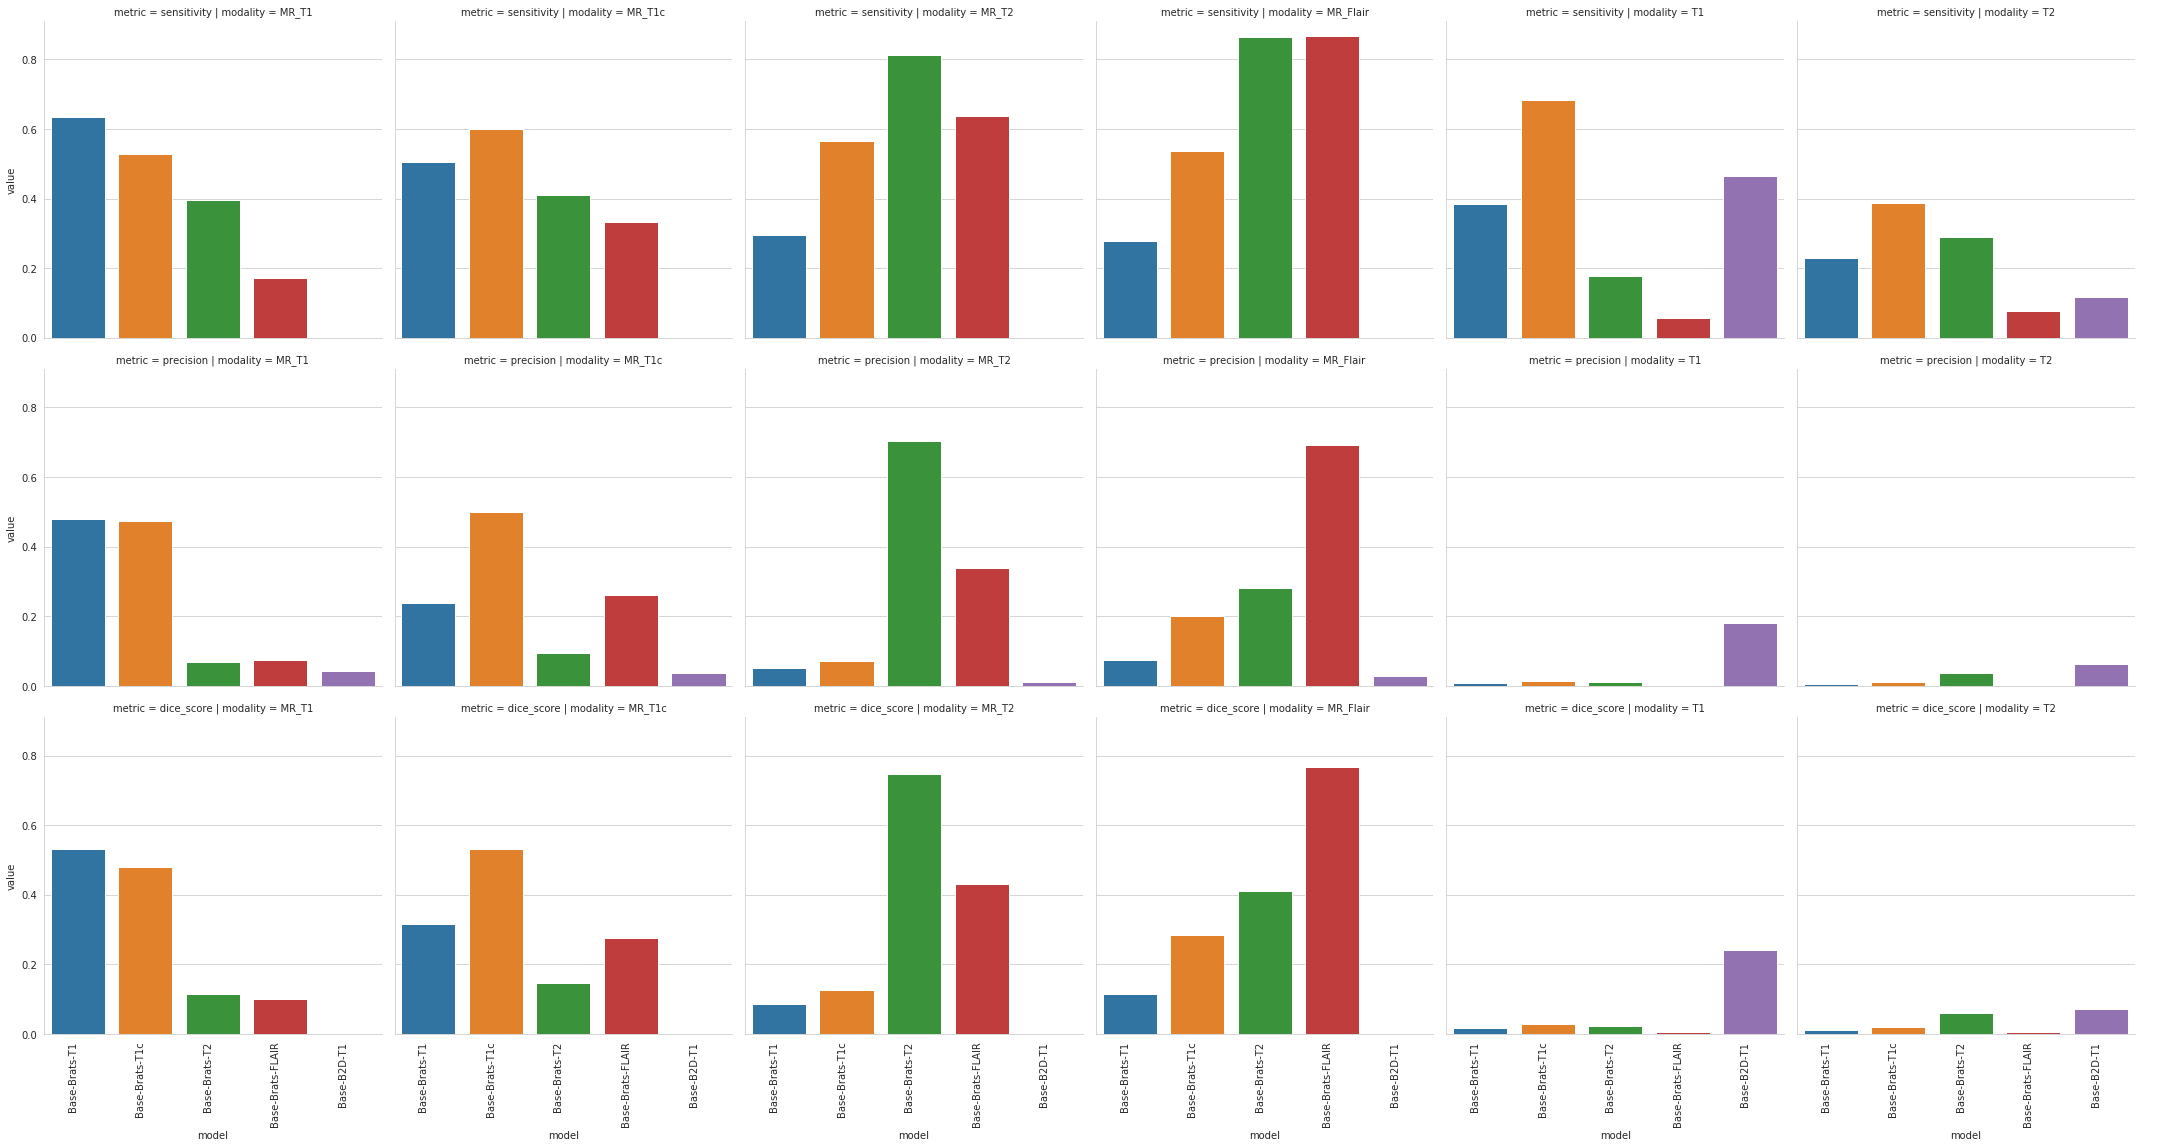

In [3]:
#Show base models
output_csv = ["transfer_performances/Segan_IO_TF2_brats_on_T1_base_performances.csv", 
              "transfer_performances/Segan_IO_TF2_brats_on_T1c_base_performances.csv", 
              "transfer_performances/Segan_IO_TF2_brats_on_T2_base_performances.csv",
              "transfer_performances/Segan_IO_TF2_brats_on_FLAIR_base_performances.csv",
              "transfer_performances/Segan_IO_TF2_bd2decide_on_T1_base_performances.csv"]
model_names = ["Base-Brats-T1",
               "Base-Brats-T1c",
               "Base-Brats-T2",
               "Base-Brats-FLAIR",
               "Base-B2D-T1"]
source_ds = ['brats', 'brats', 'brats', 'brats', 'bd2decide']
source_mod = ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair', 'T1']
performances = compare_models(output_csv, model_names, source_ds, source_mod, show_relative_performances=False, save_path='transfer_performances/base_performances.png')

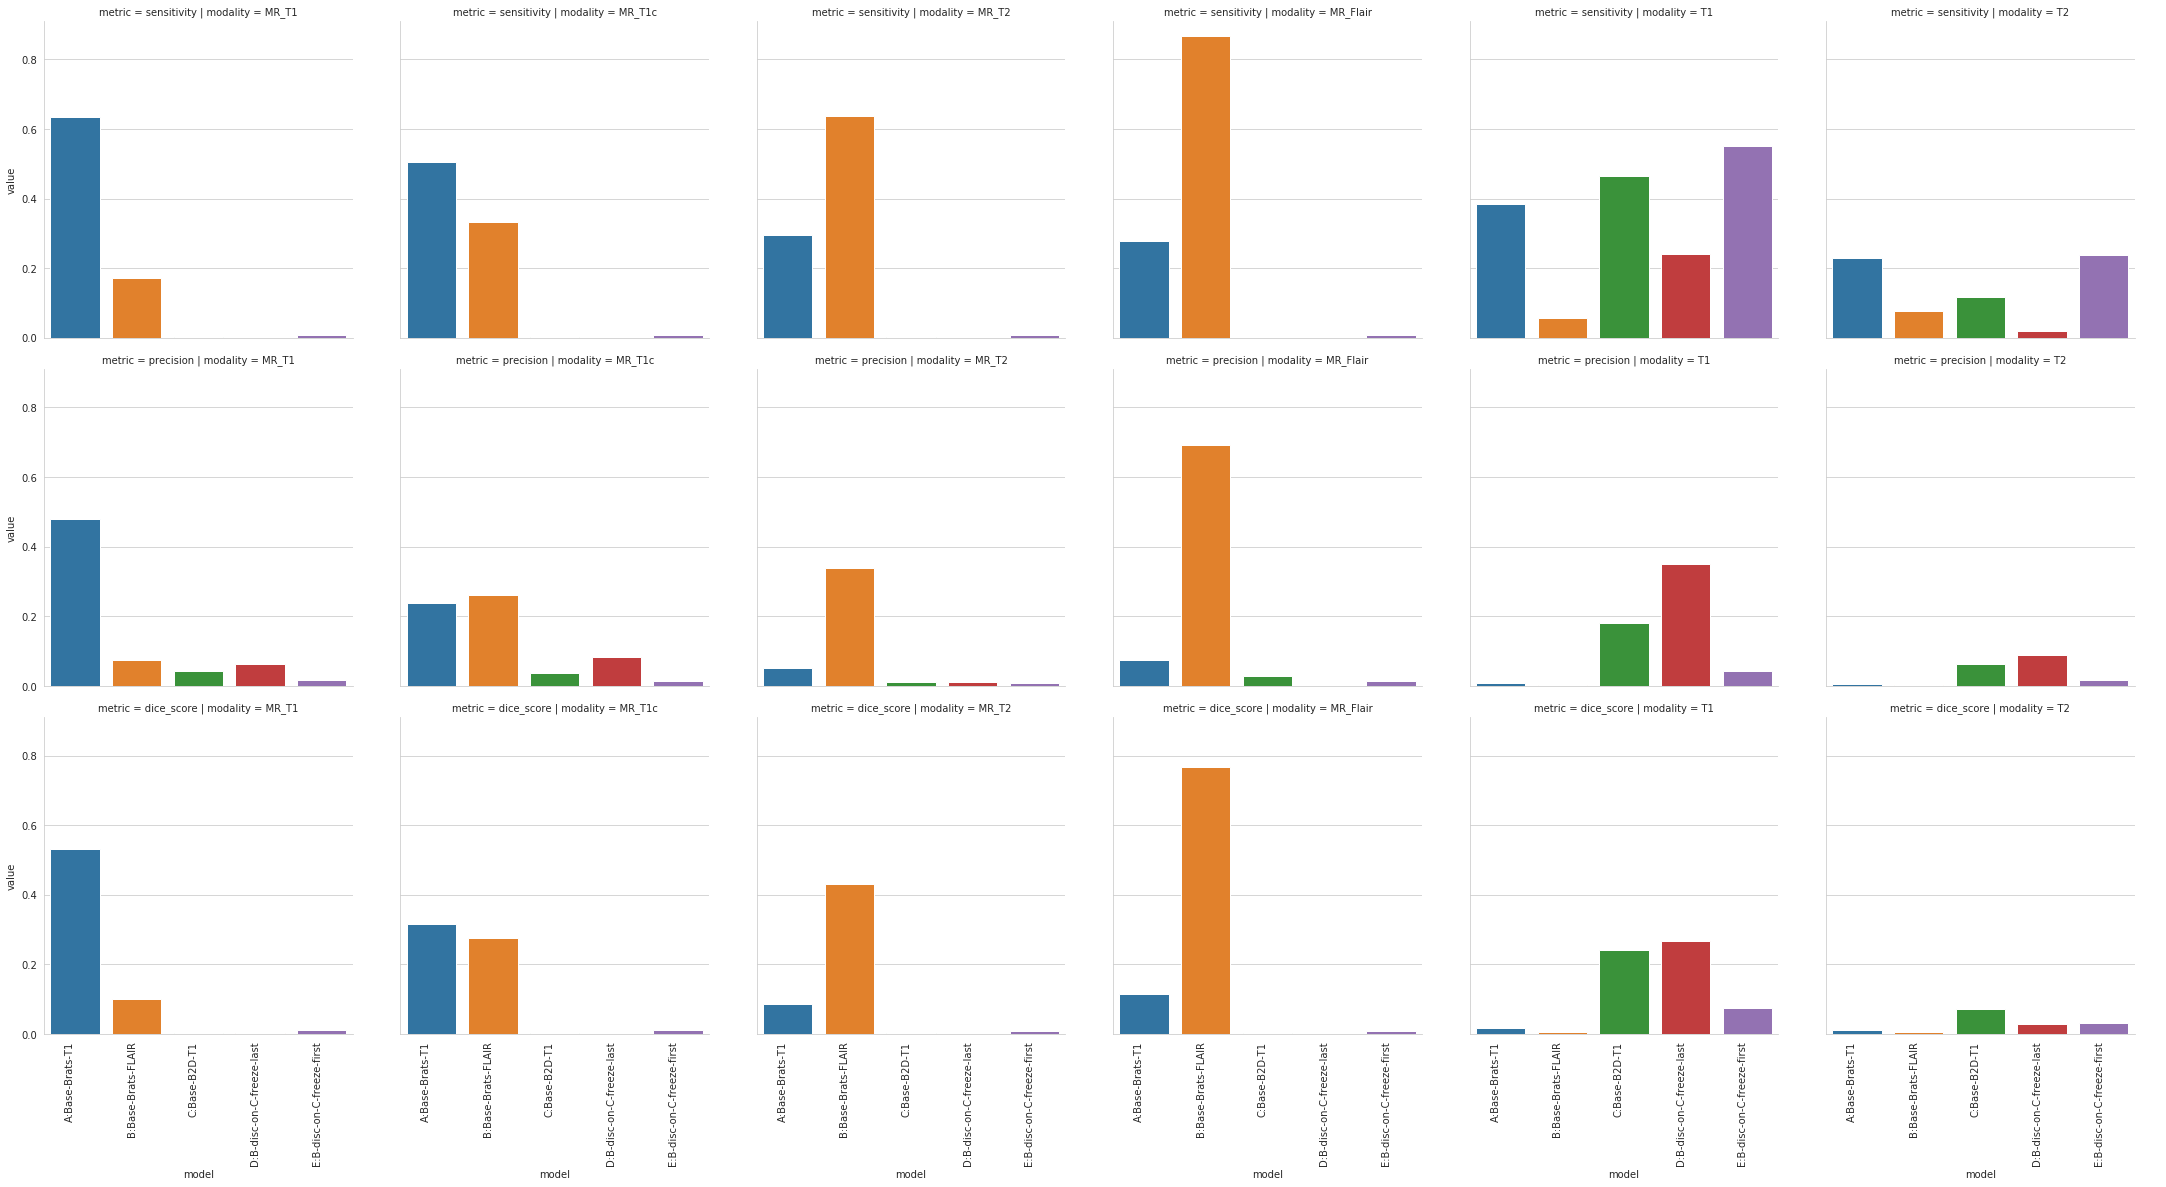

In [4]:
# Show transfer models

output_csv = ["transfer_performances/Segan_IO_TF2_brats_on_T1_base_performances.csv",
              "transfer_performances/Segan_IO_TF2_brats_on_FLAIR_base_performances.csv",
              "transfer_performances/Segan_IO_TF2_bd2decide_on_T1_base_performances.csv",
              "transfer_performances/Transfer_BratsFLAIR_disc_Bc2T1_base_performances.csv",
              "transfer_performances/Transfer_BratsFLAIR_disc_Bc2T1_lastlayers_base_performances.csv"]
model_names = ["A:Base-Brats-T1",
               "B:Base-Brats-FLAIR",
               "C:Base-B2D-T1",
               "D:B-disc-on-C-freeze-last",
               "E:B-disc-on-C-freeze-first"]
source_ds = ['brats', 'brats', 'bd2decide', 'bd2decide', 'bd2decide']
source_mod = ['MR_T1', 'MR_Flair', 'T1', 'T1', 'T1']
performances = compare_models(output_csv, model_names, source_ds, source_mod, show_relative_performances=False, save_path='transfer_performances/transfer_performances.png')

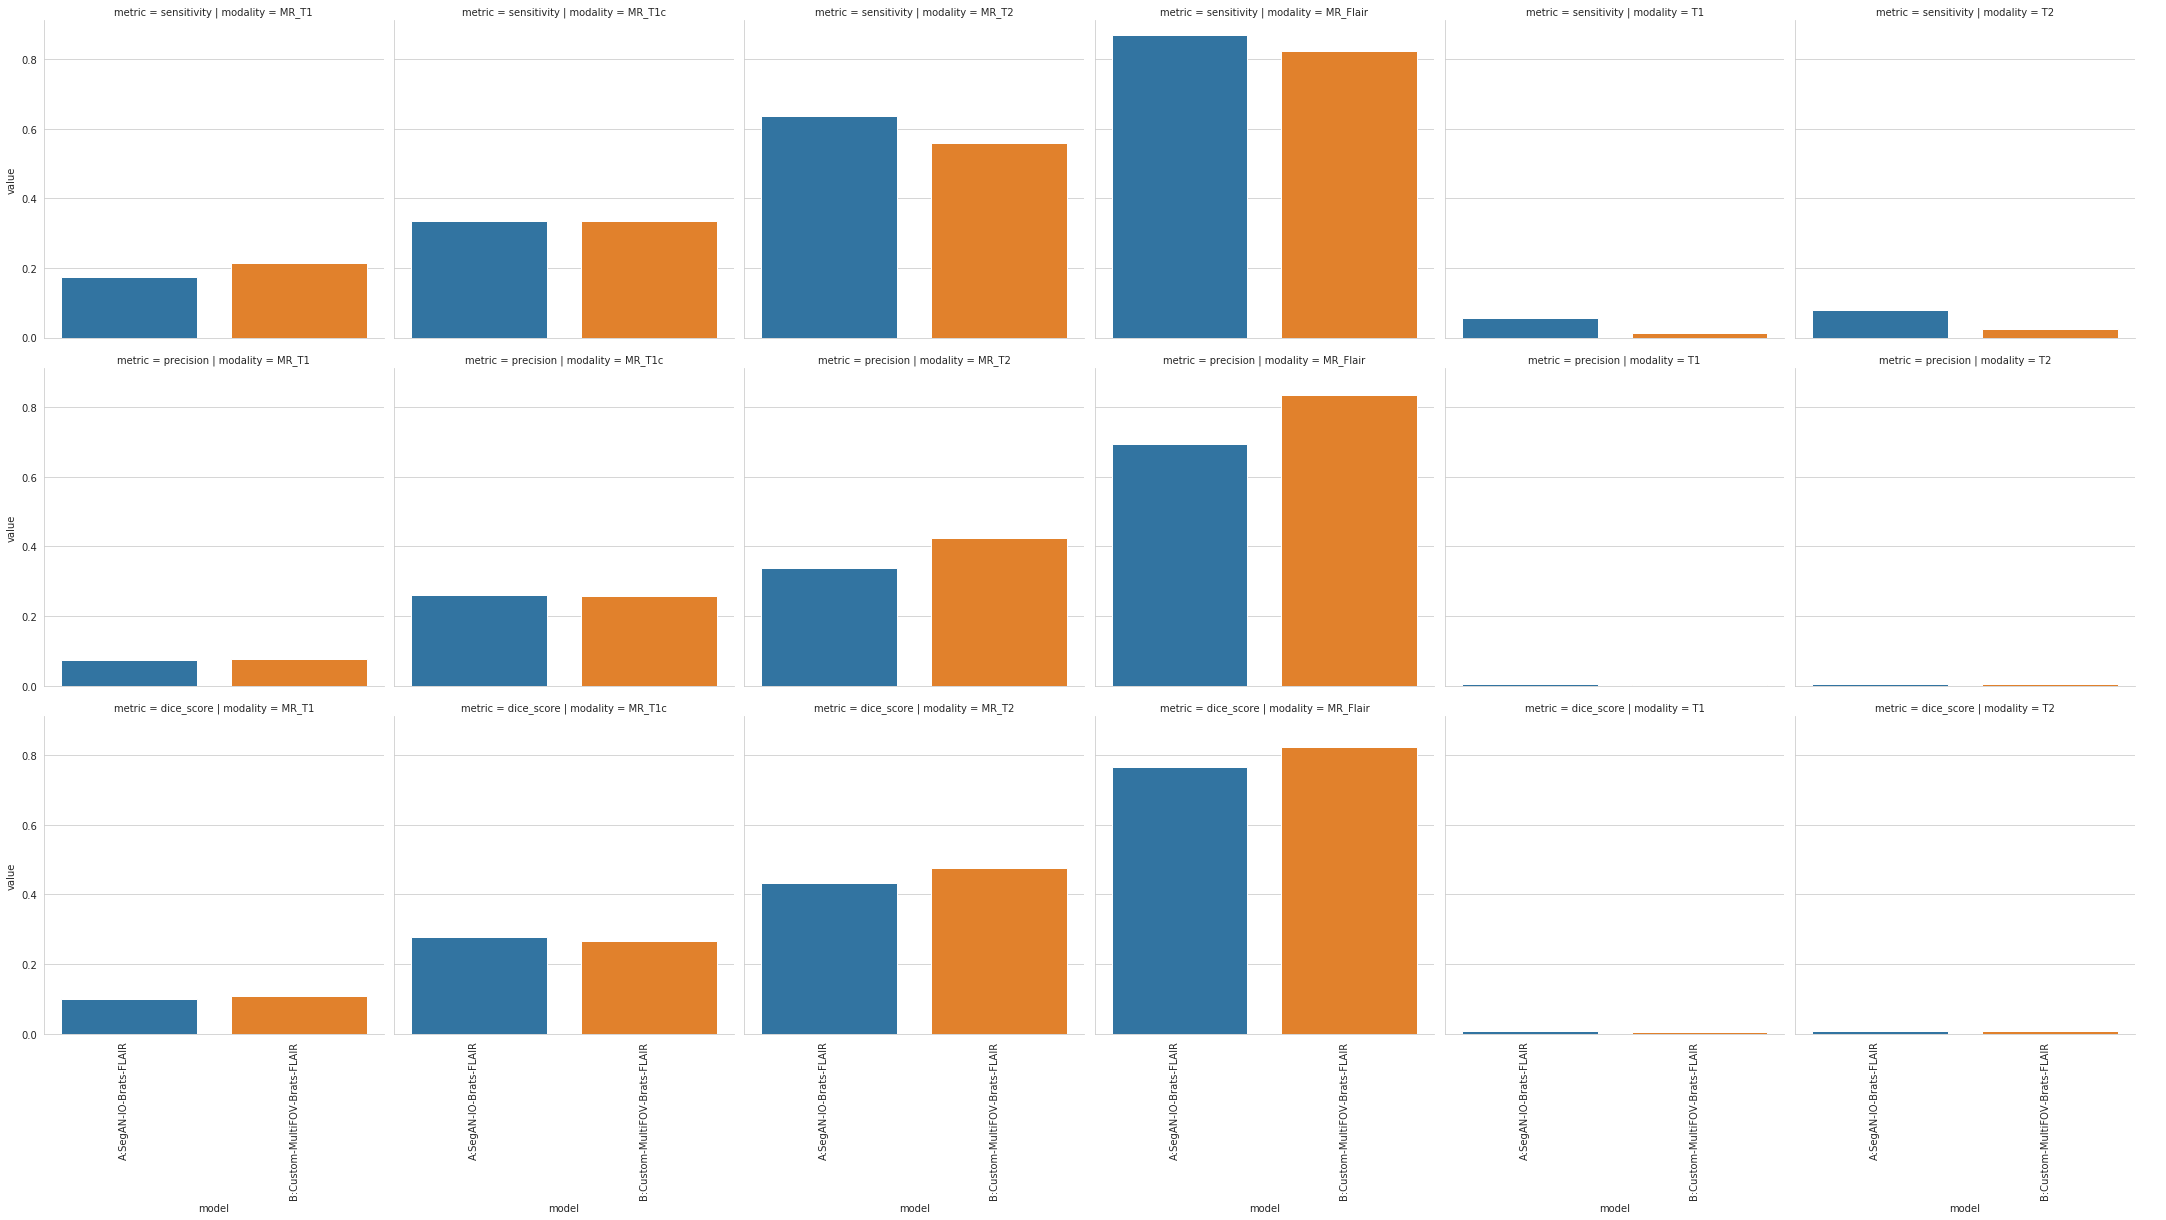

In [5]:
# Show performances of diferent models
# Show transfer models

output_csv = ["transfer_performances/Segan_IO_TF2_brats_on_FLAIR_base_performances.csv",
              "transfer_performances/Custom_MultiFOV_brats_on_FLAIR_base_performances.csv"]
model_names = ["A:SegAN-IO-Brats-FLAIR",
               "B:Custom-MultiFOV-Brats-FLAIR"]
source_ds = ['brats', 'brats']
source_mod = ['MR_Flair', 'MR_Flair']
performances = compare_models(output_csv, model_names, source_ds, source_mod, show_relative_performances=False, save_path='transfer_performances/model_performances.png')